In [2]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
from salishsea_tools import geo_tools, geo_tools, tidetools
import functools
from IPython.display import clear_output
import datetime


%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [3]:
# converts lons/lats like this "124° 01.400" to decimal format
def strLonLatToDec(lstr):
    lstr = lstr.replace(u'°',' ')
    lstr = lstr.split()
    return (int(lstr[0])+float(lstr[1])/60.0)

In [4]:
# Grab tracer data
tracer_df = pd.read_excel('/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPedit.xls')
tracer_df = tracer_df[~pd.isnull(tracer_df["Date"]) & (tracer_df["Date"] != "6/?/2015")]
tracer_df["Date"] = pd.to_datetime(tracer_df["Date"])
tracer_df = tracer_df.sort_values("Date")
tracer_df["DECIMAL_LON"] = (tracer_df["Longitude"].apply(strLonLatToDec))*(-1)
tracer_df["DECIMAL_LAT"] = (tracer_df["Latitude"].apply(strLonLatToDec))
tracer_df["STATION_LAT"] =  tracer_df.groupby("Station ID")["DECIMAL_LAT"].transform(np.median)
tracer_df["STATION_LON"] =  tracer_df.groupby("Station ID")["DECIMAL_LON"].transform(np.median)

In [5]:
# Create smaller dataframe with location of stations
station_lon_lat = tracer_df[["Station ID", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])

In [6]:
# Choose which values to add to nowcast dataframe

tracers = ["NO3"]

plot_months = ["feb", "mar", "apr", "may", "jun", "jul", "aug", "sep"]

plot_hours = np.array([12])

max_depth = 20
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

model_points = station_lon_lat["MODEL_POINT"]
model_js = [x[0] for x in model_points] 
model_is = [x[1] for x in model_points] 

stations = station_lon_lat["STATION"]

In [7]:
# Iterate through nowcast green results, grabbing certain tracers, locations, and dates/times
# Create pandas dataframe and save result

load_new_dataset = False

if load_new_dataset:
    nowcast_dir = "/results/SalishSea/nowcast-green/" #"/data/jpetrie/MEOPAR/SalishSea/results/nowcast_results/"

    month_num = {"jan": "01","feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06", "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12" }

    mixed_format_dates = os.listdir(nowcast_dir)
    number_format_dates = ["20" + x[5:7] + month_num[x[2:5]] + x[0:2] for x in mixed_format_dates]
    sorted_dirs = [mixed_format_date for (number_format_date, mixed_format_date) in sorted(zip(number_format_dates,mixed_format_dates))]
    
    dataframe_list = []
    num_files = 0
    start_time = datetime.datetime.now()
    
    for subdir in sorted_dirs:
        if os.path.isdir(nowcast_dir + '/' + subdir) and re.match("[0-9]{2}[a-z]{3}[0-9]{2}", subdir):
            month_str = subdir[2:5]
            date_str = "20" + subdir[5:7] + month_num[month_str] + subdir[0:2]
            tracer_file = "SalishSea_1h_" + date_str + "_" + date_str + "_ptrc_T.nc"
            tracer_path = nowcast_dir + "/" + subdir + "/" + tracer_file
            if os.path.isfile(tracer_path) and month_str in plot_months:
                grid_t = xr.open_dataset(tracer_path)
                result_hours = pd.DatetimeIndex(grid_t.time_centered.values).hour
                time_indices = np.where([(x in plot_hours) for x in result_hours])
                
                J, T, Z = np.meshgrid(model_js,time_indices,depth_indices, indexing = 'ij')
                I, T, Z = np.meshgrid(model_is,time_indices,depth_indices, indexing = 'ij')
                
                tracer_dataframes = []
                for trc in tracers:
                    station_slice = grid_t[trc].values[T,Z,J,I]
                    slice_xarray = xr.DataArray(station_slice,
                                     [stations,result_hours[time_indices], result_depths[depth_indices]],
                                     ["STATION", "HOUR", "DEPTH"], 
                                     trc)
                    slice_dataframe = slice_xarray.to_dataframe()
                    slice_dataframe.reset_index(inplace = True)
                    tracer_dataframes.append(slice_dataframe)
                merged_tracers = functools.reduce(lambda left,right: pd.merge(left,right,on=["STATION", "HOUR", "DEPTH"]), tracer_dataframes)
                merged_tracers["DATE"] =  pd.to_datetime(date_str, infer_datetime_format=True)
                merged_tracers["MONTH"] = int(month_num[month_str])
                dataframe_list.append(merged_tracers)

                num_files = num_files + 1
                run_time = datetime.datetime.now() - start_time
                clear_output()
                print("Files loaded:" + str(num_files))
                print("Date of most recent nowcast load: " + date_str)
                print("Time loading: ")
                print(run_time)
                print("\n\n\n")
                print(merged_tracers)

    nowcast_df = pd.concat(dataframe_list)    
    t = datetime.datetime.now()
    time_string = str(t.year) +"_"+ str(t.month) +"_"+ str(t.day) +"_"+ str(t.hour) +"_"+ str(t.minute)
    file_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/"+ time_string + ".pkl"
    nowcast_df.to_pickle(file_path)
    clear_output()
    print("Files loaded:" + str(num_files))
    print("Done, dataframe saved to: " + file_path)
    
else: 
    past_dataset_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/2016_8_4_12_30.pkl"
    nowcast_df = pd.read_pickle(past_dataset_path)

In [8]:
nowcast_df["DATE"] =  pd.to_datetime(nowcast_df["DATE"], infer_datetime_format=True)

In [9]:
nitrate_df = tracer_df[["Station ID", "Date", "DECIMAL_LON", "DECIMAL_LAT","Depth", "Nitrate + Nitrite"]]
nitrate_df.columns = ["STATION", "DATE", "DECIMAL_LON", "DECIMAL_LAT", "DEPTH", "NO3"]
nitrate_df["DATA_TYPE"] = "Measured"
nitrate_df["DAY_OF_YEAR"] = nitrate_df["DATE"].apply(lambda x: x.dayofyear)

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
nowcast_df["DAY_OF_YEAR"] = nowcast_df["DATE"].apply(lambda x: x.dayofyear)
nowcast_df["DATA_TYPE"] = "Nowcast"
combined = pd.concat([nitrate_df, nowcast_df.query("(DEPTH - 2.500011)**2 < 0.0001 | (DEPTH - 19.481785)**2 < 0.0001")])
combined["IDENTIFIER"] = combined["DATA_TYPE"] + ", Depth = " + combined["DEPTH"].apply(str)
combined = combined.sort_values(["STATION", "DATE"])

(array([  96.,   97.,   98.,   99.,  100.,  101.,  102.,  103.,  104.]),
 <a list of 9 Text xticklabel objects>)

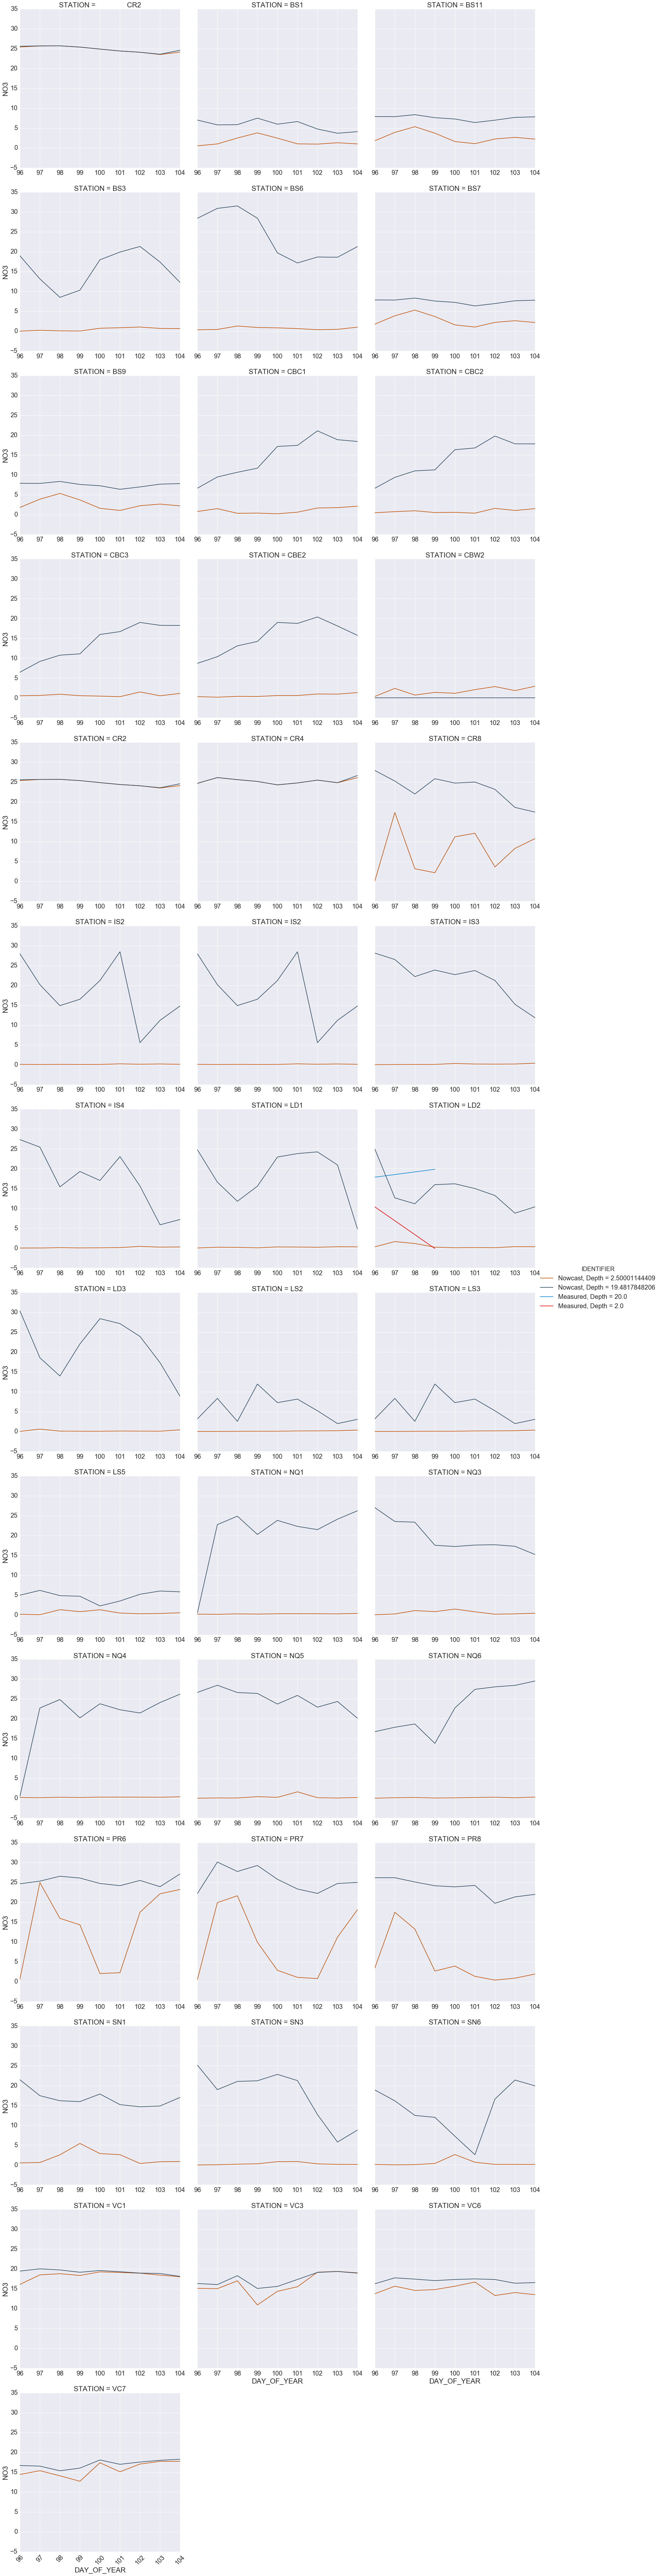

In [14]:
# Plot nowcast and measured nitrate data against day of year
# (simulation is for 2016 and data was collected in 2015)

colors = ["burnt orange", "dark grey blue", "cerulean", "red"]
cmap = sns.xkcd_palette(colors)
#pal = dict(Lunch="seagreen", Dinner="gray")
#g = sns.FacetGrid(tips, hue="time", palette=pal, size=5)

#max(nowcast_df["DAY_OF_YEAR"])

sns.set(font_scale = 2)
fg = sns.FacetGrid(data = combined[(combined["DAY_OF_YEAR"] <= 104) & (combined["DAY_OF_YEAR"] >= 96) ], col = "STATION", col_wrap=3, hue = "IDENTIFIER", size =8, sharex = False, sharey = True, palette= cmap)
fg.map(plt.plot,"DAY_OF_YEAR", "NO3").add_legend()
plt.xticks(rotation=45)